# Learn MobileNet v1 architecture from scratch with Pytorch and Tensorflow

This is my first model (MobileNet v1 architecture) in Pytorch and in Tensorflow

The link of the paper is : https://arxiv.org/pdf/1704.04861.pdf

So we get the following picture of the architecture :

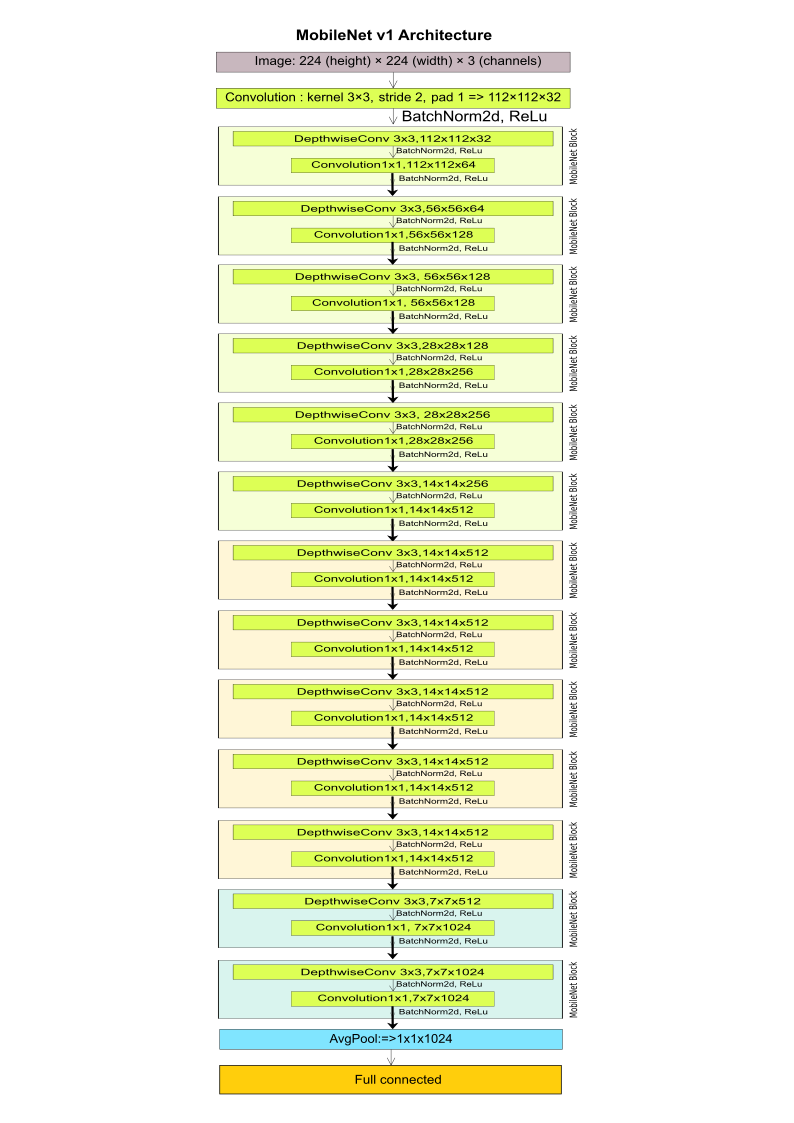

# With Pytorch

In [1]:
import torch.nn as nn
import torch
from torchsummary import summary

In [2]:
class mobilenet_block(nn.Module):
    def __init__(self, _input, _output, strides):
        super(mobilenet_block , self).__init__()
        
        self.DepthwiseConv = nn.Conv2d(_input, _input, kernel_size = (3, 3), stride = strides, padding = 1, groups = _input, bias = False) # groups give us the DepthwiseConv
        self.Conv = nn.Conv2d(_input, _output, kernel_size = (1, 1), stride = (1, 1), padding = 0, bias = False)
        self.BatchNorm_1 = nn.BatchNorm2d(_input)
        self.BatchNorm_2 = nn.BatchNorm2d(_output)
        self.Relu = nn.ReLU(inplace = True)
        
    def forward(self , x):
        
        x = self.DepthwiseConv(x)
        x = self.BatchNorm_1(x)
        x = self.Relu(x)
        
        x = self.Conv(x)
        x = self.BatchNorm_2(x)
        x = self.Relu(x)        
         
        return x

In [3]:
class Mobilenet(nn.Module):
    def __init__(self):
        super(Mobilenet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size = (3, 3), stride = (2, 2) , padding  = 1, bias = False)
        self.batch1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU(inplace = True)
        self.mobileN_1 = nn.Sequential(
                                       mobilenet_block(32, 64, 1),
                                       mobilenet_block(64, 128, 2),
                                       mobilenet_block(128, 128, 1),
                                       mobilenet_block(128, 256, 2),
                                       mobilenet_block(256, 256, 1),
                                       mobilenet_block(256, 512, 2)            
                                       )
        
        self.mobileN_2 = mobilenet_block(512, 512, 1)
                 
        self.mobileN_3 = nn.Sequential(
                                       mobilenet_block(512, 1024, 2),
                                       mobilenet_block(1024, 1024, 1),
                                       )
        self.AvgPool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(1024, 1000)
        
    def forward(self,x):
        
        x = self.conv1(x)
        x = self.batch1(x)
        x = self.relu1(x)
        x = self.mobileN_1(x)
        
        for _ in range (5):
            x = self.mobileN_2(x)        
        
        x = self.mobileN_3(x)
        x = self.AvgPool(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        
        return x

In [4]:
dev = torch.device("cuda") 

model_1 = Mobilenet().to(dev)
print(summary(model_1,(3,224,224)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              ReLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              ReLU-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 64, 112, 112]           2,048
       BatchNorm2d-8         [-1, 64, 112, 112]             128
              ReLU-9         [-1, 64, 112, 112]               0
  mobilenet_block-10         [-1, 64, 112, 112]               0
           Conv2d-11           [-1, 64, 56, 56]             576
      BatchNorm2d-12           [-1, 64, 56, 56]             128
             ReLU-13           [-1, 64, 56, 56]               0
           Conv2d-14          [-1, 128,

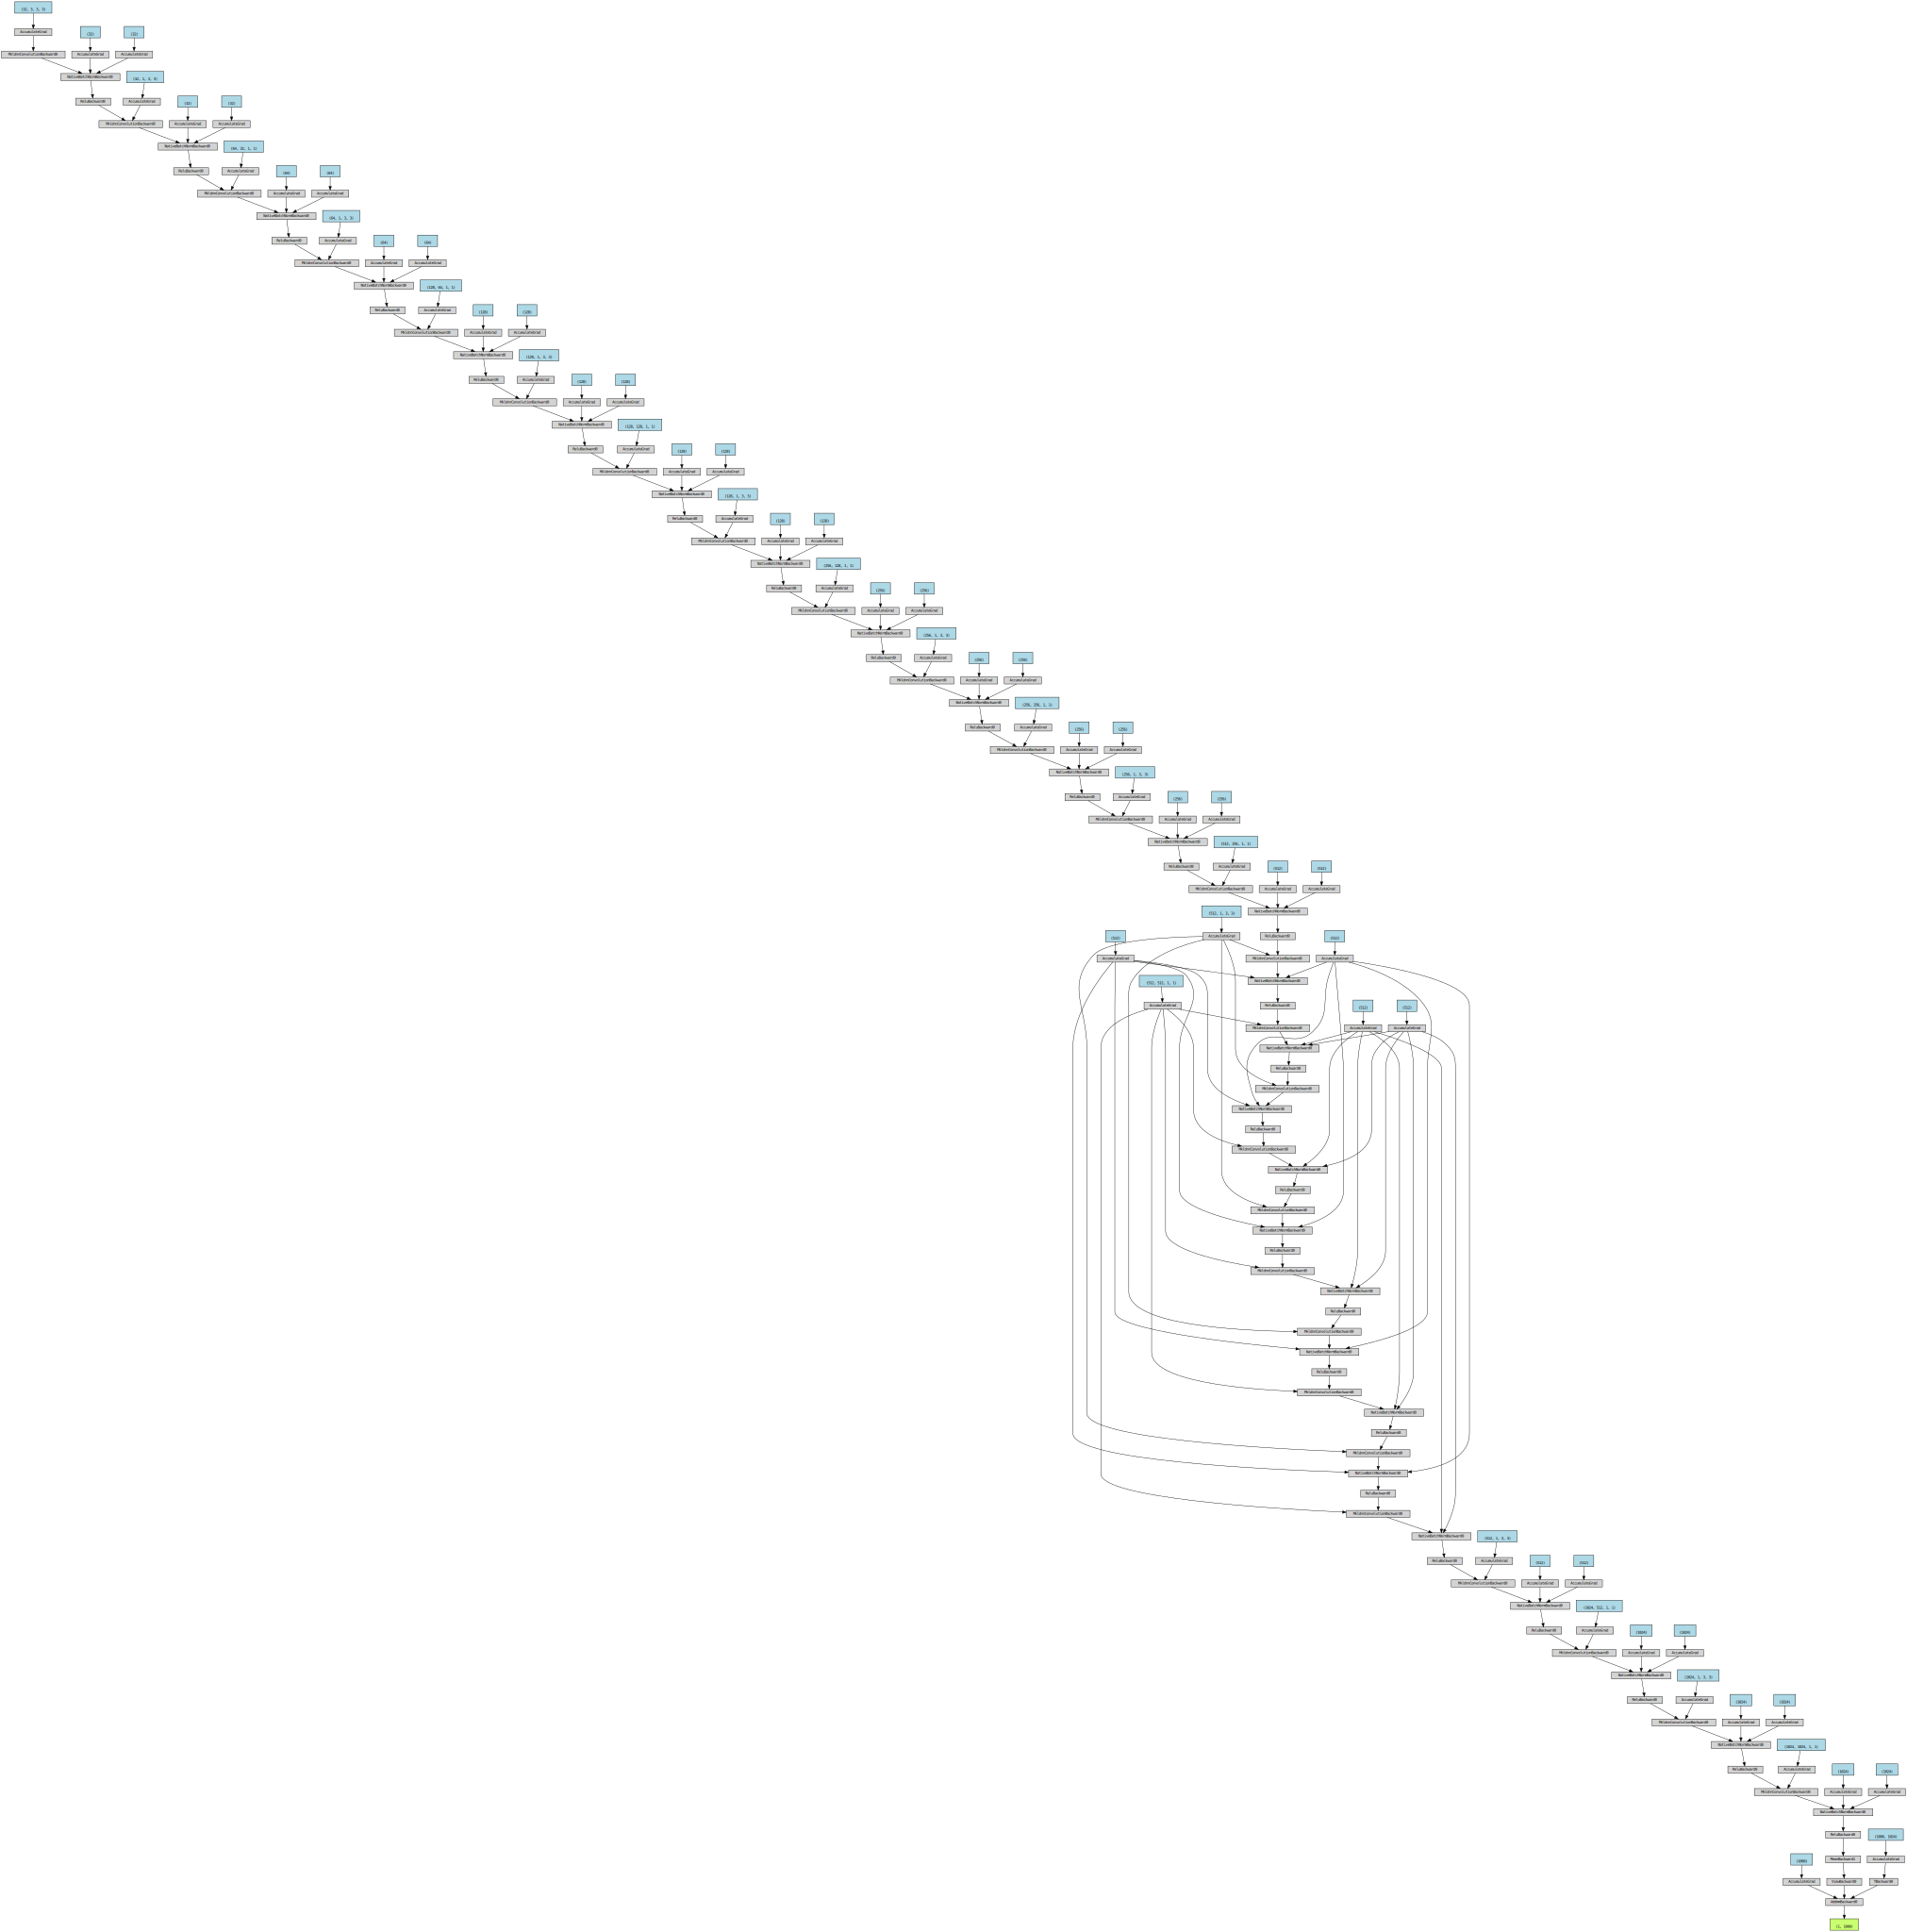

In [5]:
from torchviz import make_dot

x = torch.randn(1, 3, 224, 224)

model_1_cpu = Mobilenet()
model_1_cpu_out = model_1_cpu(x)

#g = make_dot(out, params=None)
#g.view()
make_dot(model_1_cpu_out, params = None)

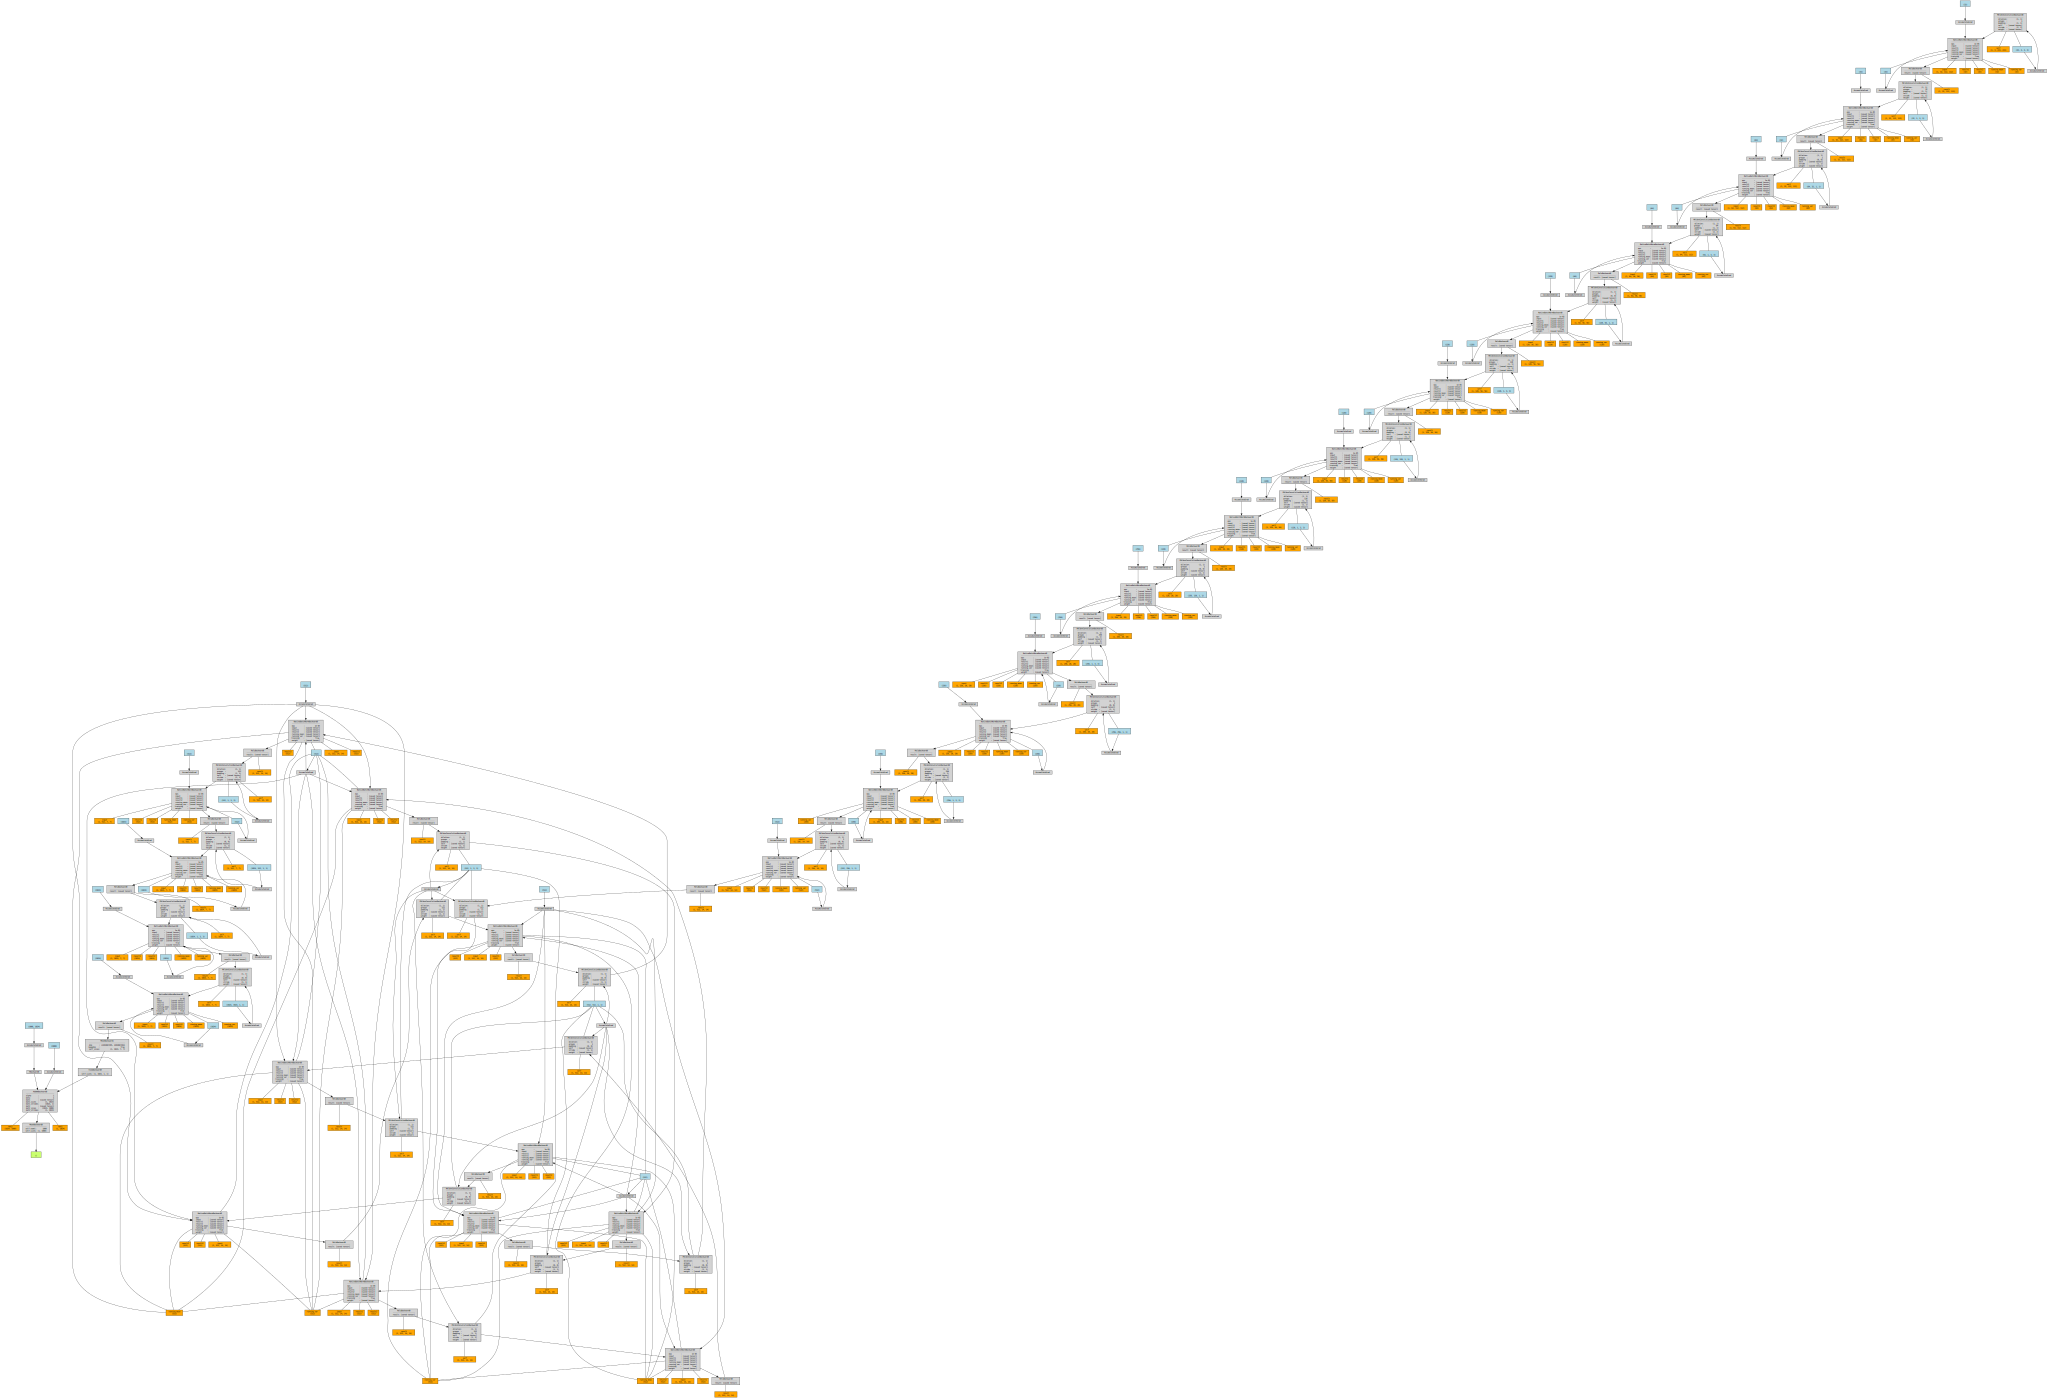

In [6]:
make_dot(model_1_cpu_out.mean(), params = None, show_attrs = True, show_saved = True)

# With Tensorflow

In [7]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, BatchNormalization, Activation, AveragePooling2D, Dense 

In [8]:
# Here is how to build a subclass : https://www.tensorflow.org/api_docs/python/tf/keras/Model
# https://stackoverflow.com/questions/55109696/tensorflow-difference-between-tf-keras-layers-layer-vs-tf-keras-model

class mobilnet_block(tf.keras.Model):
    def __init__(self, filters, strides):
        super().__init__()
        
        self.DepthwiseConv = DepthwiseConv2D(kernel_size = 3, strides = strides, padding = 'same', use_bias = False)
        self.Conv = Conv2D(filters = filters, kernel_size = 1, strides = 1, use_bias = False)
        self.BatchNorm_1 = BatchNormalization()
        self.BatchNorm_2 = BatchNormalization()
        self.Relu = Activation('relu')
        
    def call(self, inputs):
        
        x = self.DepthwiseConv(inputs)
        x = self.BatchNorm_1(x)
        x = self.Relu(x)
        
        x = self.Conv(x)
        x = self.BatchNorm_2(x)
        x = self.Relu(x)
        
        return x

In [9]:
class mobilenet(Sequential):
    
    def __init__(self, input_shape):
        super().__init__()
        
        self.add(Conv2D(filters = 32, kernel_size = 3, strides = 2, padding = 'same', input_shape = input_shape, use_bias = False)) # To get the same number as in pytorch I need to put ",use_bias = False"
        self.add(BatchNormalization(axis=3 , epsilon=1e-05, center = False , scale = False)) # to get 64 like in paytorch I need to put center=False , scale=False
        self.add(Activation('relu'))
        
        self.add(mobilnet_block(filters = 64, strides = 1))        
        self.add(mobilnet_block(filters = 128, strides = 2))
        self.add(mobilnet_block(filters = 128, strides = 1))
        self.add(mobilnet_block(filters = 256, strides = 2))
        self.add(mobilnet_block(filters = 256, strides = 1))
        self.add(mobilnet_block(filters = 512, strides = 2))
        
        for _ in range (5):
            self.add(mobilnet_block(filters = 512, strides = 1))
            
        self.add(mobilnet_block(filters = 1024, strides = 2))
        self.add(mobilnet_block(filters = 1024, strides = 1))
        
        self.add(AveragePooling2D(pool_size = 7, strides = 1, data_format = 'channels_first'))

        self.add(Dense(units = 1000))

In [10]:
input_layer = (224,224,3)
model_2 = mobilenet(input_shape = input_layer)

In [11]:
model_2.summary()

Model: "mobilenet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 112, 112, 32)      864       
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 32)      64        
_________________________________________________________________
activation (Activation)      (None, 112, 112, 32)      0         
_________________________________________________________________
mobilnet_block (mobilnet_blo (None, 112, 112, 64)      2720      
_________________________________________________________________
mobilnet_block_1 (mobilnet_b (None, 56, 56, 128)       9536      
_________________________________________________________________
mobilnet_block_2 (mobilnet_b (None, 56, 56, 128)       18560     
_________________________________________________________________
mobilnet_block_3 (mobilnet_b (None, 28, 28, 256)       35

### The result of the Total parameters are not the same between pytorch and tensorflow this is because of the batchnormalization

https://stackoverflow.com/questions/60079783/difference-between-keras-batchnormalization-and-pytorchs-batchnorm2d

I correct only the first batchnorm to get first batchnorm have the same result

Perhaps their are also other parameters in addition to the batchnorm which also affects the result.

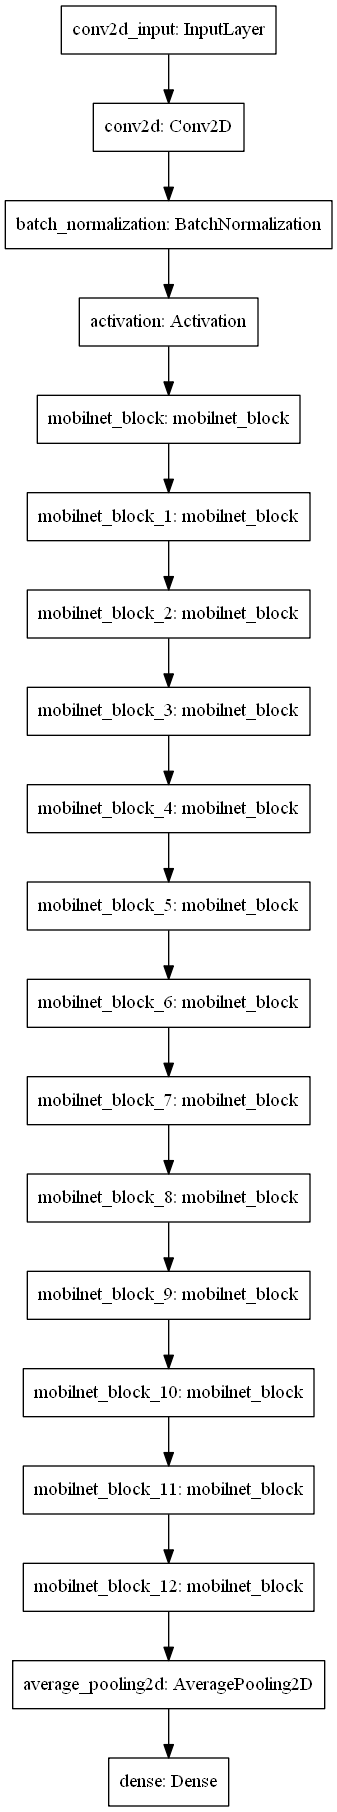

In [12]:
tf.keras.utils.plot_model(model_2)